# Simulated Mobile Health Data and Anomaly Detection Example
This notebook is intended to combine and provide examples of elements of the simulation and anomaly detection pipeline.

In [6]:
import sys
import importlib
# Make imports work
sys.path.insert(0, '../')

In [2]:
import pandas as pd
from mhealth_anomaly_detection import load_refs as lr
from mhealth_anomaly_detection import simulate_daily as sd
from mhealth_anomaly_detection import anomaly_detection as ad
from mhealth_anomaly_detection import plots

## Simulate data with weekly anomalies

Simulating data...


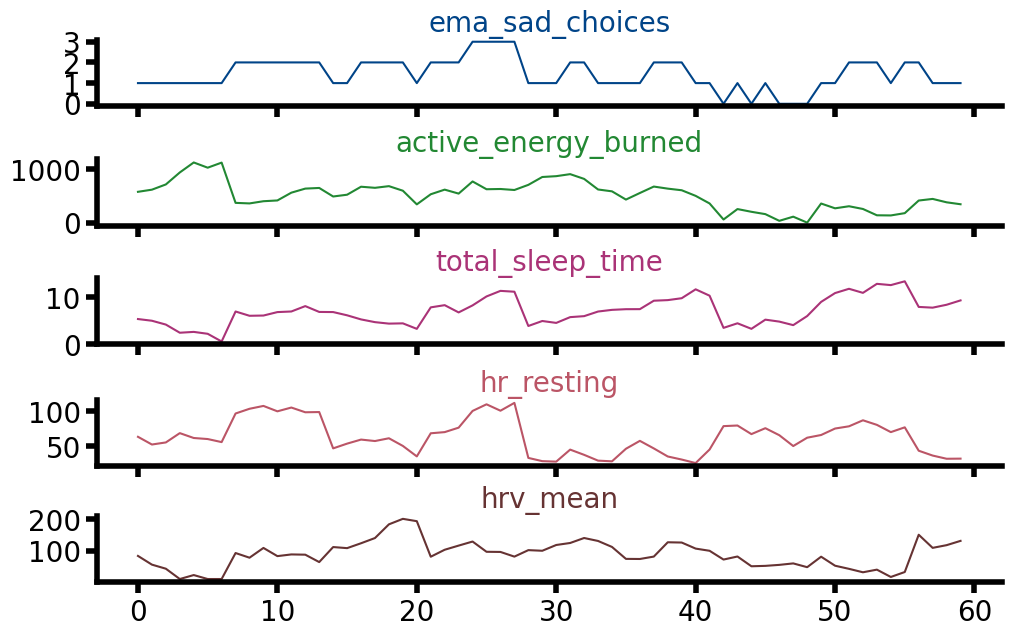

In [4]:
# Feature parameters for simulation
palette = lr.get_colors('../lib/colors.json')
all_feature_params = lr.get_all_feature_params('../lib/feature_parameters.json')
sim_type = 'weeklyAnomaly'
feature_params = all_feature_params[sim_type]

# Simulate daily data with weekly anomalies
# Frequency and scale of anomalies set in lib/feature_parameters.json
simulator = sd.RandomAnomalySimulator(
    feature_params=feature_params,
    n_days=60,
    n_subjects=2,
    sim_type=sim_type,
    cache_simulation=False,
)
simulated_data = simulator.simulateData()

# Get 1 subject and plot their data over time
subject_data: pd.DataFrame = simulated_data.loc[
    simulated_data.subject_id == simulated_data.subject_id.unique()[0],
    :
].reset_index()
fig, ax = plots.lineplot_features(
    subject_data,
    [
        'ema_sad_choices',
        *feature_params.keys()
    ],
    palette=palette,
)

## Anomaly Detection

### Simple 3-component PCA based

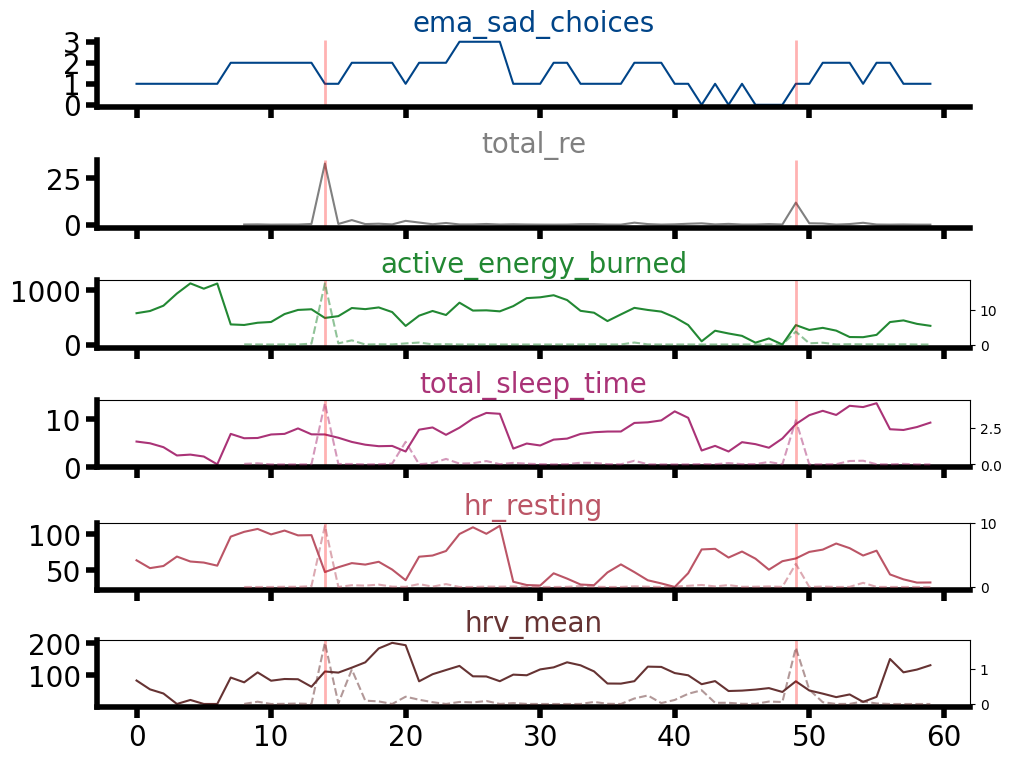

In [7]:
importlib.reload(ad)

# Rolling 7 day PCA based anomaly detection
anomalyDetector = ad.BaseRollingAnomalyDetector(
    features=feature_params.keys(),
    window_size=7
)

# Get reconstruction error and use to do anomaly labeling
reconstruction_error, pca_components = anomalyDetector.getReconstructionError(subject_data)
subject_data['anomaly'] = anomalyDetector.labelAnomaly(reconstruction_error)
subject_data['total_re'] = reconstruction_error['total_re']

# Plot features with anomalies labeled
palette = lr.get_colors('../lib/colors.json')
fig, axes = plots.lineplot_features(
    subject_data,
    [
        'ema_sad_choices',
        'total_re',
        *feature_params.keys()
    ],
    palette=palette,
    anomaly_col='anomaly'
)

plots.overlay_reconstruction_error(
    reconstruction_error,
    fig,
    axes,
    [
        'ema_sad_choices',
        'total_re',
        *feature_params.keys()
    ],
    palette=palette,

);